<a href="https://colab.research.google.com/github/DuncanFerguson/GITHUB_REPOSITORY/blob/main/Project_03_Duncan_Ferguson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [326]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os
import pathlib
from pathlib import Path

from IPython.display import Image
%matplotlib inline
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
import struct

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

!pip install ignite

# from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
# from ignite.metrics import Accuracy, Loss
 
np.set_printoptions(precision=3)

TensorFlow version: 2.8.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Objectives: Neural Network Training with TensorFlow
- 1). Read in a classifiable set of images from the internet using python, and transform those images into training, test, and validation TensorFlow Datasets that can be used for DNN training
- 2). Understand the ethical implication of the dataset I've identified, both in terms of the legality of its use and in regards to any inherent biases present in the training data.
- 3). Preprocess the training dataset to ensure images are on the same scale, and that the dimensionality of the data is correct for DNN training.
- 4). Use the TensorFlow Keras API to create a customer feedforward NN model with many layers that will be compiled and trained to classify my image data
- 5). Choose customer activation functions, layer parameters, layer regularization parameters, optimizers, loss functions, and performance metrics for my custom NN model
- 6). Create a Keras Estimator for my customer Keras model and use it to train my model and asses its performance
- 7). Visualize my estimator's training performance and decision boundary using MLxtend


# Experiment Objective

### Objective: Describe the dataset I am analyzing, including the TOS and ethical considerations discussed in Lecture 7 & 8. 

- The data set that I chose to analyize was the dog breeds from Stanford.
- http://vision.stanford.edu/aditya86/ImageNetDogs/

- Dataset Reference
  - Primary:
  
    Aditya Khosla, Nityananda Jayadevaprakash, Bangpeng Yao and Li Fei-Fei. Novel dataset for Fine-Grained Image Categorization. First Workshop on Fine-Grained Visual Categorization (FGVC), IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2011.  [pdf]  [poster]  [BibTex]

  - Secondary:

    J. Deng, W. Dong, R. Socher, L.-J. Li, K. Li and L. Fei-Fei, ImageNet: A Large-Scale Hierarchical Image Database. IEEE Computer Vision and Pattern Recognition (CVPR), 2009.  [pdf]  [BibTex]

- The terms of service allow anyone to use the data set for machine learning models. This is one of the main reasons I chose this dataset. It was ready to go, and it had dog breeds. I evently want to design a dog door to use a camera to only let my dog in. Also, just a general interest in dogs.

### Objective: Why did I choose the training examples I did for training my model?

 - When choosing the training examples I took random portions from each dog breed to try and train the model. I then had to resample until I got an even spread of different types of dogs to not over weight the model?

### Objective: How are the images classified? 

- The images come with labels then the dog breeds. There was a little bit of file name manipulation to extract the dog breed, but otherwise it was readyto come off the shelf. 


### Objective Note: For this step do not use any of the datasets in the tensorflor_datasets library.

- The Data set came from Stanford

# Data Collection and Preprocessing

### Objective:  Am I accessing an API? Scaping a website? Downloading an archive?

- The data is getting downloaded from a Stanford Archive. The Dataset Reference is above. 

### Objective: Write the necessary Python Cod to retrieve and store the training examples to be used in the model



In [2]:
from google.colab import drive
drive.mount('content/',force_remount=True)
os.getcwd()

Mounted at content/


'/content'

In [3]:
# Going to the right fold to unzip the images. Learned this the hard way
%cd content/MyDrive/ML_Colab/Project_3/Images

/content/content/MyDrive/ML_Colab/Project_3/Images


In [4]:
# Downloading the images
# !wget 'images' 'http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar'
# !tar -xf ./images.tar &>/dev/null

In [5]:
# Grabbing the Images
root_dir = pathlib.Path("./Images")

In [6]:
# Creating a data frame of the images
root_dir = Path("./Images")  # path to dataset root directory

# create a mapping from directory name to label index
image_dir = {n.name: i for i, n in enumerate(sorted(root_dir.iterdir()))}
image_dir
fpaths = []
labels = []
for d in root_dir.iterdir():
    for f in d.iterdir():
        labels.append(image_dir[d.name])
        fpaths.append(str(f))

df = pd.DataFrame(data={"fpath": fpaths, "label": labels})
df.head()

,fpath,label
0,Images/n02085620-Chihuahua/n02085620_10621.jpg,0
1,Images/n02085620-Chihuahua/n02085620_10976.jpg,0
2,Images/n02085620-Chihuahua/n02085620_11238.jpg,0
3,Images/n02085620-Chihuahua/n02085620_11258.jpg,0
4,Images/n02085620-Chihuahua/n02085620_1152.jpg,0


In [7]:
# Showing the shape
df.shape

(20580, 2)

In [8]:
# Cleaining up the file path and extracting the breed
breed_long_list = []
# # Finding the back space
for row in enumerate(df['fpath']):
  breed = df.iloc[row[0]]['fpath'][df.iloc[row[0]]['fpath'].rfind("-")+1:df.iloc[row[0]]['fpath'].rfind("/"):]
  breed_long_list.append(breed)

In [9]:
df['breed'] = breed_long_list
df.head()

,fpath,label,breed
0,Images/n02085620-Chihuahua/n02085620_10621.jpg,0,Chihuahua
1,Images/n02085620-Chihuahua/n02085620_10976.jpg,0,Chihuahua
2,Images/n02085620-Chihuahua/n02085620_11238.jpg,0,Chihuahua
3,Images/n02085620-Chihuahua/n02085620_11258.jpg,0,Chihuahua
4,Images/n02085620-Chihuahua/n02085620_1152.jpg,0,Chihuahua


In [10]:
# Showing all the dog breeds and their cooresponding labels
dog_dict_keys = dict(zip(df['breed'], df['label']))
display(dog_dict_keys)

{'Afghan_hound': 9,
 'African_hunting_dog': 119,
 'Airedale': 40,
 'American_Staffordshire_terrier': 29,
 'Appenzeller': 89,
 'Australian_terrier': 42,
 'Bedlington_terrier': 30,
 'Bernese_mountain_dog': 88,
 'Blenheim_spaniel': 5,
 'Border_collie': 81,
 'Border_terrier': 31,
 'Boston_bull': 44,
 'Bouvier_des_Flandres': 82,
 'Brabancon_griffon': 110,
 'Brittany_spaniel': 64,
 'Cardigan': 112,
 'Chesapeake_Bay_retriever': 58,
 'Chihuahua': 0,
 'Dandie_Dinmont': 43,
 'Doberman': 85,
 'English_foxhound': 16,
 'English_setter': 61,
 'English_springer': 66,
 'EntleBucher': 90,
 'Eskimo_dog': 97,
 'French_bulldog': 94,
 'German_shepherd': 84,
 'Gordon_setter': 63,
 'Great_Dane': 95,
 'Great_Pyrenees': 105,
 'Greater_Swiss_Mountain_dog': 87,
 'Ibizan_hound': 22,
 'Irish_setter': 62,
 'Irish_terrier': 33,
 'Irish_water_spaniel': 70,
 'Irish_wolfhound': 19,
 'Italian_greyhound': 20,
 'Japanese_spaniel': 1,
 'Kerry_blue_terrier': 32,
 'Labrador_retriever': 57,
 'Lakeland_terrier': 38,
 'Leonberg

In [72]:
# Selecting the two dog breeds that I have
# This also just makes the df smaller
# df = df[df.breed.isin(['beagle','Bernese_mountain_dog'])]
# df.head()

,fpath,label,breed
1181,Images/n02088364-beagle/n02088364_10108.jpg,11,beagle
1182,Images/n02088364-beagle/n02088364_10206.jpg,11,beagle
1183,Images/n02088364-beagle/n02088364_10362.jpg,11,beagle
1184,Images/n02088364-beagle/n02088364_10731.jpg,11,beagle
1185,Images/n02088364-beagle/n02088364_10947.jpg,11,beagle


In [81]:
df.shape

(20580, 3)

In [11]:
# Turnning the dataframe into a file list
file_list = df['fpath'].tolist()

# Displaying a short clip of the file list
display(file_list[1:10])

['Images/n02085620-Chihuahua/n02085620_10976.jpg',
 'Images/n02085620-Chihuahua/n02085620_11238.jpg',
 'Images/n02085620-Chihuahua/n02085620_11258.jpg',
 'Images/n02085620-Chihuahua/n02085620_1152.jpg',
 'Images/n02085620-Chihuahua/n02085620_11337.jpg',
 'Images/n02085620-Chihuahua/n02085620_11696.jpg',
 'Images/n02085620-Chihuahua/n02085620_11818.jpg',
 'Images/n02085620-Chihuahua/n02085620_11948.jpg',
 'Images/n02085620-Chihuahua/n02085620_1205.jpg']

In [12]:
# check if tensorflow see the GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [13]:
# checking the name of the GPU
!nvidia-smi

Sat Aug 13 08:11:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |    391MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
# Making a small df for image testing
df_s = df.tail(6).copy()
file_list_s = df_s['fpath'].tolist()

In [15]:
file_list_s

['Images/n02108915-French_bulldog/n02108915_5813.jpg',
 'Images/n02108915-French_bulldog/n02108915_6142.jpg',
 'Images/n02108915-French_bulldog/n02108915_623.jpg',
 'Images/n02108915-French_bulldog/n02108915_971.jpg',
 'Images/n02108915-French_bulldog/n02108915_9666.jpg',
 'Images/n02108915-French_bulldog/n02108915_9899.jpg']

Image shape:  (333, 500, 3)
Image shape:  (375, 500, 3)
Image shape:  (500, 375, 3)
Image shape:  (500, 499, 3)
Image shape:  (333, 500, 3)
Image shape:  (500, 375, 3)


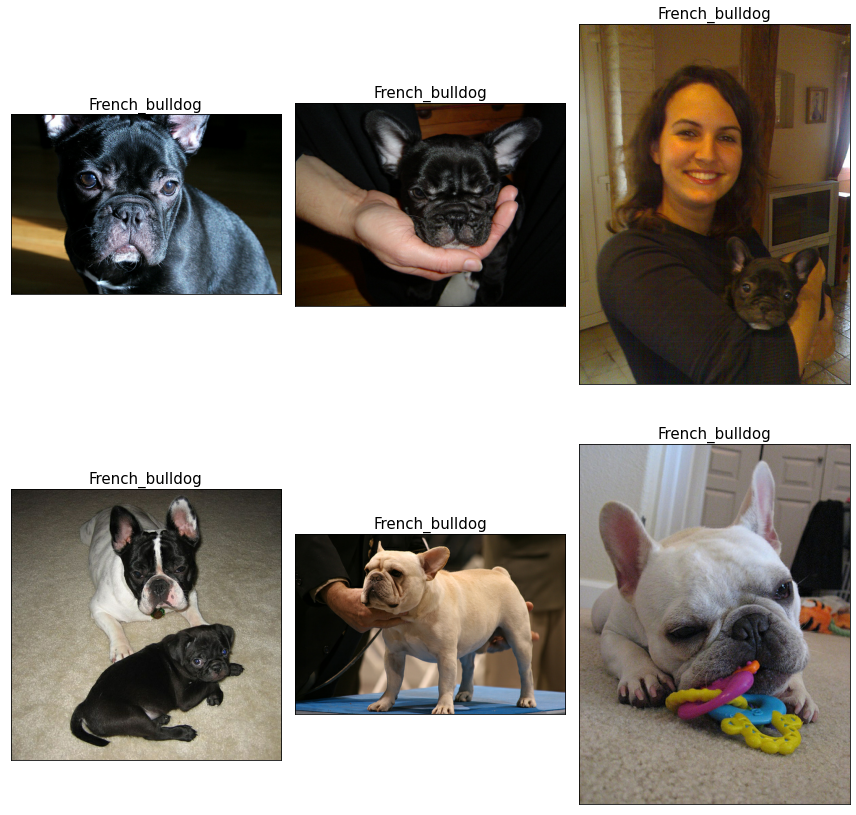

In [16]:
# Displaying the shortlist of dogs
fig = plt.figure(figsize=(12, 12))
for i,file in enumerate(file_list_s):
    img_raw = tf.io.read_file(file)
    img = tf.image.decode_image(img_raw)
    print('Image shape: ', img.shape)
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(df_s.iloc[i]['breed'], size=15)

plt.tight_layout()
plt.show()

### Once the Images are acquired, build a TensorFlow Input Pipeline that will load my images from disk. Similar to the chat13_part1 example Jupyter Notebook, create an initial TensorFlow Dataset that maps file locations to classification labels.




### Then map the dataset using my input pipeline, and convert the file locations to the actual image data.

In [17]:
def load_and_preprocess(path, label):
    """Takes an image file and turnes it into a tensor"""
    img_width, img_height = 120, 120
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [img_width, img_height])
    # image /= 255.0
    return image, label

Setting up two types of splits.

In [18]:
def train_data_full(df):
  df_train, df_test = train_test_split(df, random_state=42, test_size=0.2, shuffle=True)
  return df_train, df_test

In [19]:
def train_data_x_y(df):
  x_train, x_test, y_train, y_train = train_test_split(df['fpath'], df['label'], test_size=0.2, random_state=42, shuffle=True)
  return x_train, x_test, y_train, y_train

In [20]:
# Testing quick train and split and tf
df_train, df_test = train_data_full(df)
df_train.head()

,fpath,label,breed
16375,Images/n02091244-Ibizan_hound/n02091244_4778.jpg,22,Ibizan_hound
16615,Images/n02092002-Scottish_deerhound/n02092002_...,26,Scottish_deerhound
10098,Images/n02105641-Old_English_sheepdog/n0210564...,78,Old_English_sheepdog
7677,Images/n02099849-Chesapeake_Bay_retriever/n020...,58,Chesapeake_Bay_retriever
18717,Images/n02110806-basenji/n02110806_4242.jpg,101,basenji


In [103]:
file_list = df['fpath']
display(file_list)

# Grabbing the unique labels
labels = df_train['breed']
unique_labels = np.unique(df['breed'])

display(len(unique_labels))
# setting up x and y
x = file_list

# This is one hot encoding Y
y = [label == unique_labels for label in labels]
# y = labels
display(x[0])
display(y[0])

0           Images/n02085620-Chihuahua/n02085620_10621.jpg
1           Images/n02085620-Chihuahua/n02085620_10976.jpg
2           Images/n02085620-Chihuahua/n02085620_11238.jpg
3           Images/n02085620-Chihuahua/n02085620_11258.jpg
4            Images/n02085620-Chihuahua/n02085620_1152.jpg
                               ...                        
20575    Images/n02108915-French_bulldog/n02108915_6142...
20576    Images/n02108915-French_bulldog/n02108915_623.jpg
20577    Images/n02108915-French_bulldog/n02108915_971.jpg
20578    Images/n02108915-French_bulldog/n02108915_9666...
20579    Images/n02108915-French_bulldog/n02108915_9899...
Name: fpath, Length: 20580, dtype: object

119

'Images/n02085620-Chihuahua/n02085620_10621.jpg'

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [252]:
# Creating the training and test batchs
train_num = 1000
x_train, x_test, y_train, y_test = train_test_split(x[:train_num], y[:train_num],
                                                    test_size=0.2, random_state=42)

In [253]:
# Bringing the training data back in proper list form
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()

Creating Batches to feed the data into the model

In [242]:
def create_train_batch(x, y, b_size=32):
  """Creating Batches for the training set"""
  display("Training Batches Being Created")
  tf_train = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))

  # Shuffling the training model
  tf_train = tf_train.shuffle(buffer_size=len(x))
  train_batch = tf_train.map(load_and_preprocess).batch(b_size)
  return train_batch

In [243]:
def create_test_batch(x, y, b_size=64):
  """Creating Batches for the training set"""
  display("Test Batches Being Created")
  tf_test = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
  test_batch = tf_test.map(load_and_preprocess).batch(b_size)
  return test_batch

In [244]:
display(len(x_train))
display(len(x_test))
display(len(y_train))
display(len(y_test))
train_data = create_train_batch(x=x_train, y=y_train)

800

200

800

200

'Training Batches Being Created'

In [245]:
# Displaying the element specs for this training batch
train_data.element_spec

(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 119), dtype=tf.bool, name=None))

In [246]:
# Creating the testing batch
test_data = create_test_batch(x=x_test, y=y_test)

'Test Batches Being Created'

In [247]:
#  SHowing the element for the test
test_data.element_spec

(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 119), dtype=tf.bool, name=None))

### The result of this section should be atleast two functions that return TensorFlow Datasets, one for training and one for validation, that can be used to train my DNN

- Train_data_full returns a training data set and a validation data set
though I will probably change this to have both x_train and y_train etc.
- load_and_preprocess; I believe this returns TensorFlow Datasets. Or I call it right below there. Will ahve to revisit this.

### Note: If you have more images than avilable memory, you can explore alternative methods to stream in my data using tf.data

- I should be set here.

### Note: I said functions that return TensorFlow Data sets because you cannot use a Dataset created outside an Estimator's execution context inside an Steimator. I will recieve a 'Attempting to capture an EagerTensor with out building a function' error if I try. I can use the function to create for providing my input data inside your estimator

- I've definitely started to see this error, and will come back and edit this section.

### Note: to save on memory, you may want to resize your images before loading them into your application using something like ImageMagick.

- I resized the images because I was having trouble with making tensors of unequal capity. I took the mod of 18 but that may change in the future.

# TensorFlow Model Creation

### Objective: Create a customer TensforFlow DNN model using the Keras API, similar to the "Simplifying implementations of common architectures vis the Keras API" Section of the ch14_part1 example.


In [355]:
shape_in = [None, 120, 120, 3] # Batch, hieght, weights, channels
shape_out = len(unique_labels)


def make_model(in_shape=shape_in, out_shape=shape_out):
  """This function makes a model"""
      # Setup the model layers
  model = tf.keras.Sequential([tf.keras.layers.Dense(units=shape_out,
                              activation="softmax")])
  
  model.compute_output_shape(input_shape=shape_in)
  model.add(tf.keras.layers.GlobalAveragePooling2D())
  model.compute_output_shape(input_shape=shape_in)
    # Compile the model
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])
  model.build(shape_in)

  return model  

## compile:
model = make_model()
display(model.summary())
## train:
hist = model.fit(x=train_data, validation_data=test_data, epochs=1, batch_size=32, verbose=True)

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_174 (Dense)           (None, 120, 120, 119)     476       
                                                                 
 global_average_pooling2d_7   (None, 119)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
Total params: 476
Trainable params: 476
Non-trainable params: 0
_________________________________________________________________


None

25/25 [==============================] - 150s 6s/step - loss: 4.7894 - accuracy: 0.0025 - val_loss: 4.7798 - val_accuracy: 0.0000e+00


In [271]:
shape_in

[None, 120, 120, 3]

In [215]:
# Creating a callback
import datetime
log_path = "/ML_Colab/Project_3/Logs"

In [357]:
%reload_ext tensorboard

def tf_board_callback():
    # Creating a log of the tensors for callback
    logs = os.path.join(log_path, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logs)

In [358]:
# Create Early Stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

In [360]:
def model_training(epoch=1):
  """Training the model"""
  
  # Creating the model
  model = make_model()
  
  # Making a Tensorboard
  tf_board = tf_board_callback()

  # Fitting the model
  model.fit(x=train_data, epochs=epoch, validation_data=test_data, validation_freq=1,
            callbacks=[tf_board, stop_early])

  return model


In [361]:
model = model_training()

25/25 [==============================] - 4s 124ms/step - loss: 4.7829 - accuracy: 0.0075 - val_loss: 4.7793 - val_accuracy: 0.0000e+00


## Building the Keras API based off Simplifying implementations of common architectures via the Keras API


### Objective: My DNN should contain at least two hidden layers.


### Objective: Need to defined appropriate feature columns for the input to the model, base on the feature data that I extracted in the second section. 


### Objective: I should consider all the configuration parameters discussed in class for each layer in the model and for the model compilation itself:
-- 1). Keras Initializers
-- 2). Keras Regularizers
-- 3). Activations
-- 4). Keras Optimizers
-- 5). Keras Loss Function
-- 6). Keras Metric


### Objective: After I have decided on the relevant configuration options listed for each layer of my DNN, and for the compiulation of my model, Describe my choices and what affect each option has on my DNN in a markdown cell.


### Objective: Describe why I chose the width and depth that I did for my NN model


### Objective: This is one of the most important parts of this projec, so spend some time understanding what options are available to me, and choose configuration options appropriate to my problem.


### Objective:The out come of this section should be a compiled TensorFlow model that's ready to be used in an Estimator!
### Objective: Note: Whether I use tf.keras.Sequential, the Keras functional API, or create a class that inherits from tf.keras.Model, to create my NN model is up to me!
### Objective: Note: I am not require to create custom Keras layers to us in the model, I can use existing ones that are available in tf.keras.layers

# TensorFlow Estimator Creation and Training

- This is where I will take the compiled model that I created in the third section and use it to create a custom Keras Estimator.
-Similar to the "Creating a custom Estimator from an existing Keras model" section of the ch14_part3 exampl, I will use tf.keras.estimator.model_to_estimator to create a Keras Estimator from my compiled model.
- Once I have the estimator created, I will then train it against the training data I created in part two

# TensorFlow Estimator Performance Evaluation and Visualization

- I will begin by visualizing the loss and the evaluation metric that I decided on in part three.
- This will be accomplished by calling the fit method directly on my model and plotting the reulting history object.
- I can base my visualization after code block contained in the "Solving an XOR classification problem" Section of the ch14_part1 exampl.
-Take the trained Estimator I created in part 4 and evaluate it against my validation data.
- Summarize my finding
- Discuss the performance of the mdoel and the accuracy of the created decision boundary
- Did my model and estimator work well?